In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg
import pickle
%matplotlib inline


In [27]:
def read_images(path):
    ret = []
    images = glob.glob(path)
    for fname in images:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret.append(img)
    ret = np.array(ret)
    return ret


vehicle = read_images("vehicles/KITTI_extracted/*")
non_vehicle = read_images("non-vehicles/GTI/*")


(5966, 64, 64, 3)
(3900, 64, 64, 3)


In [80]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.array(features)

vehicle_feat = extract_features(vehicle)
print(vehicle_feat.shape)

non_vehicle_feat = extract_features(non_vehicle)
print(non_vehicle_feat.shape)


def combine(vehicle, non_vehicle):
    label = np.hstack((np.ones(len(vehicle)), np.zeros(len(non_vehicle))))
    feat = np.append(vehicle, non_vehicle, axis=0)
    return feat, label

combine_feat, label = combine(vehicle_feat, non_vehicle_feat)

data = {
    "feature": combine_feat,
    "label": label
}
pickle_file = "data.p"
import pickle
pickle.dump(data, open(pickle_file, "wb"))


(5966, 4932)
(3900, 4932)


In [66]:
with open(pickle_file, mode='rb') as f:
    data = pickle.load(f)

X_train, y_train = data['feature'], data['label']
print(X_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))
nb_classes = len(np.unique(y_train))

(9866, 4932)
(9866,)
2


In [68]:
from sklearn.cross_validation import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_state)


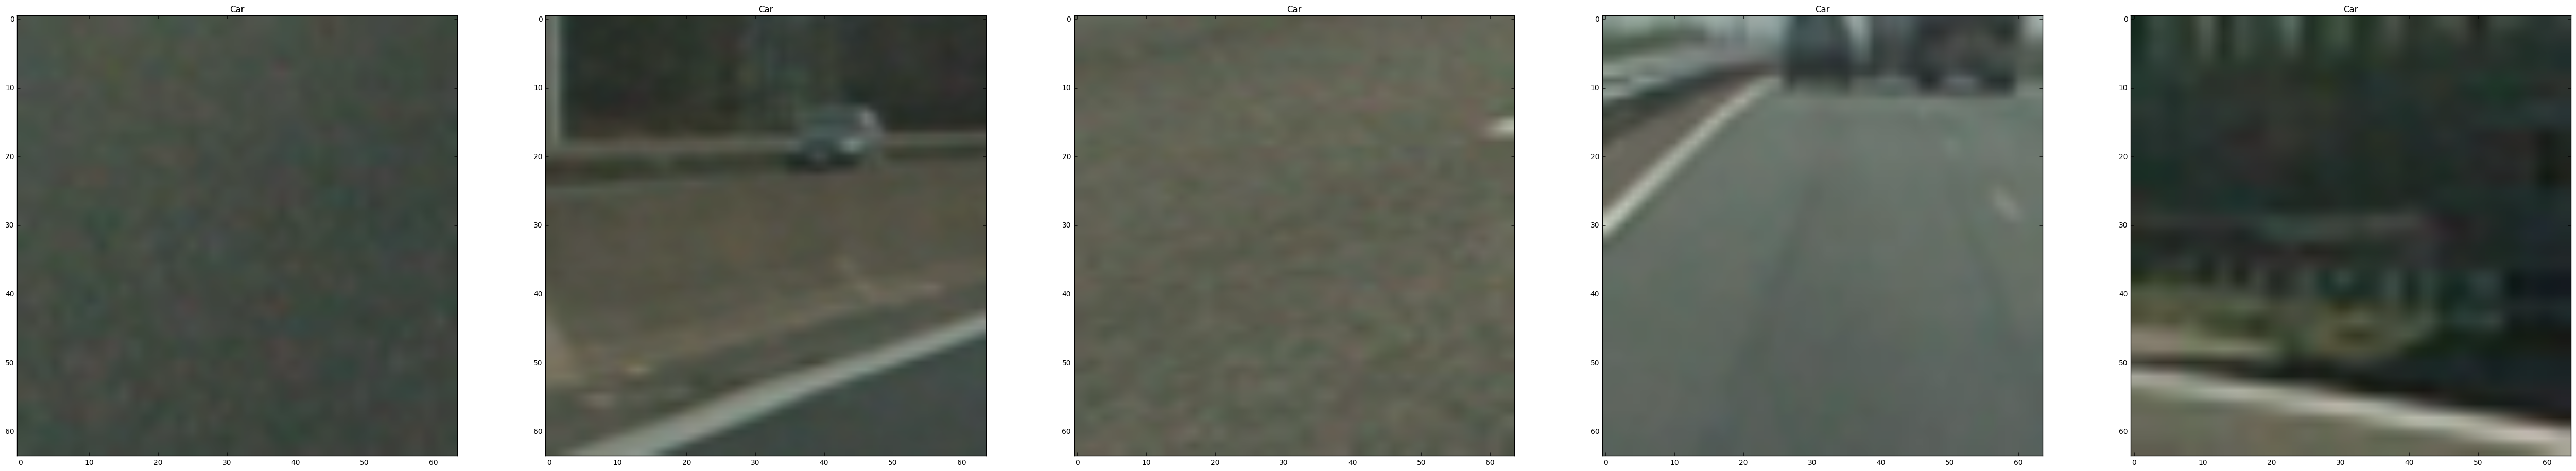

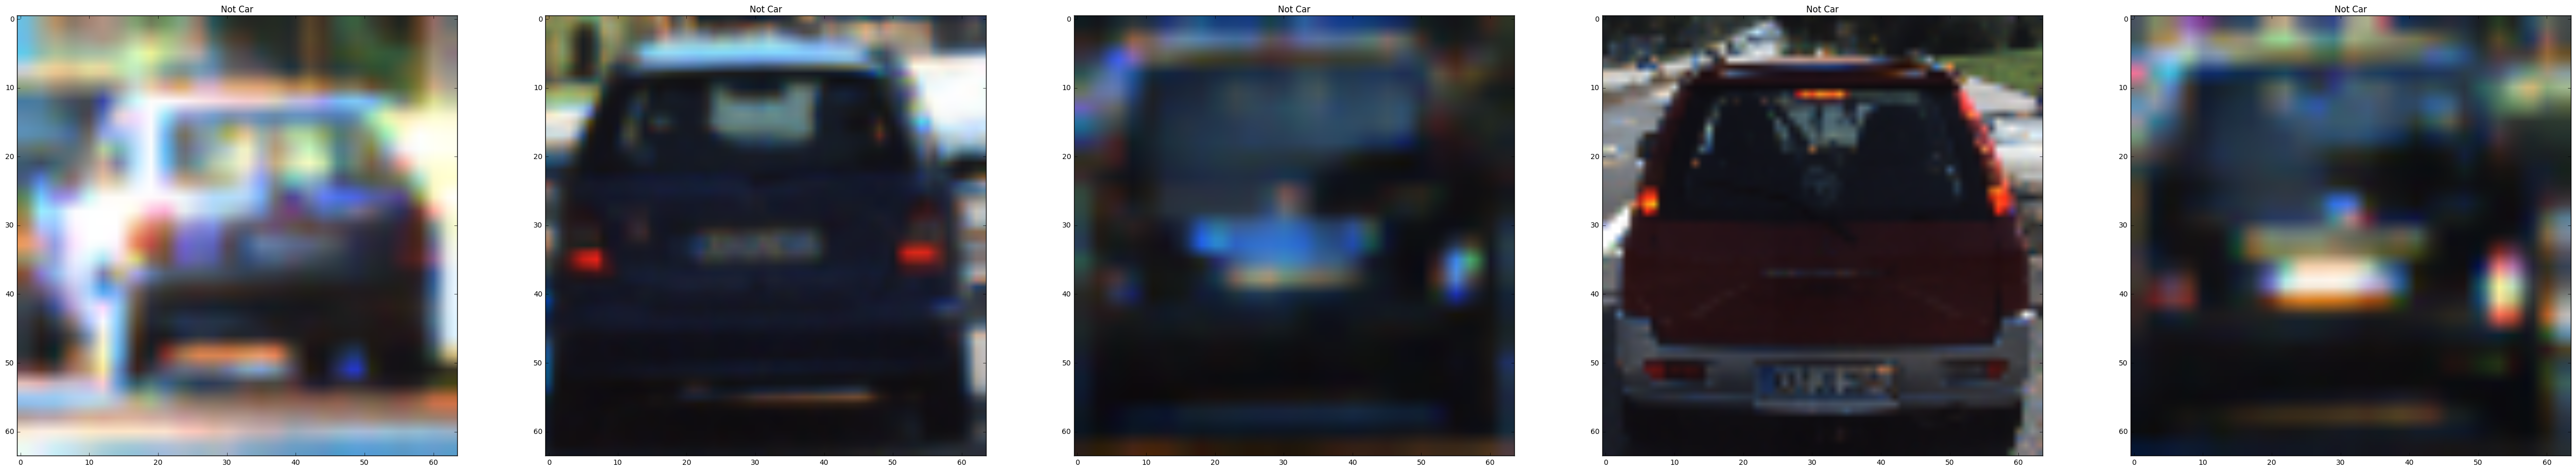

In [102]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train, y_train)
svc.score(X_test, y_test)

f, x = plt.subplots(1, 5, figsize=(64, 64))
x = x.ravel()

for i in range(0, 5):
    test_feat = extract_features([non_vehicle[i]])
    p = svc.predict(test_feat)
    if p == 0:
        x[i].imshow(non_vehicle[i])
        x[i].set_title('Car')
    else:
        x[i].imshow(non_vehicle[i])
        x[i].set_title('Not Car')

plt.figure(1)
f, x = plt.subplots(1, 5, figsize=(64, 64))
for i in range(0, 5):
    test_feat = extract_features([vehicle[i]])
    p = svc.predict(test_feat)
    if p == 0:
        x[i].imshow(vehicle[i])
        x[i].set_title('Car')
    else:
        x[i].imshow(vehicle[i])
        x[i].set_title('Not Car')

/home/pratyushverma/installation/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2 cars found


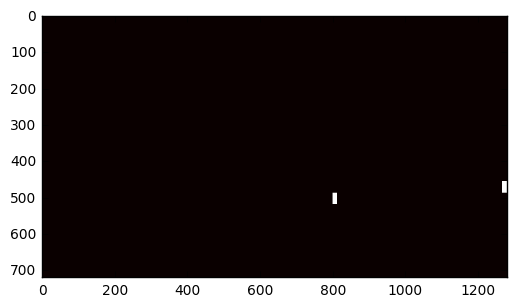

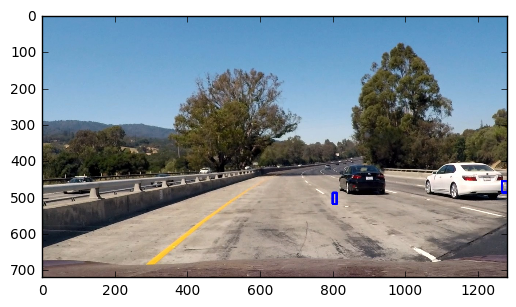

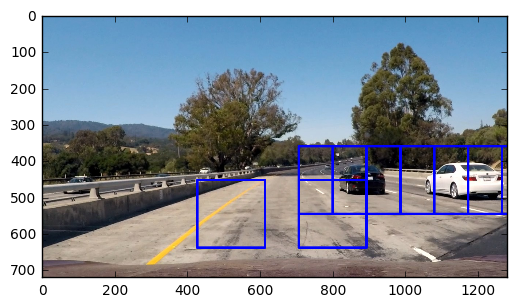

In [166]:

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label
def process_image(image):
    image_xy = image.shape
    original_image = image
    deleted_h = int(image_xy[0]/2)
    deleted_w = int(image_xy[1]/3)
    image = image[image_xy[0]/2:image_xy[0],0:image_xy[1]]
    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
    crop_sizes = [[64, 64], [96, 96], [128, 128], [186, 186]]
    
    for crop_size in crop_sizes:

        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                           xy_window=(crop_size[0], crop_size[1]), xy_overlap=(0.5, 0.5))
        cars = []

        for window in windows:
            cropped_image = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

            feat = extract_features([cropped_image])
            is_car = svc.predict(feat)
            if is_car == 1:
                window = [(window[0][0] + deleted_w, window[0][1]+ deleted_h), (window[1][0]+ deleted_w, window[1][1]+ deleted_h)]
                cars.append(window)
    #             if len(cars) == 5:
    #                 break

        heat = add_heat(heat, cars)
    heat = apply_threshold(heat, 11)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    print(labels[1], 'cars found')
    draw_img = draw_labeled_bboxes(np.copy(original_image), labels)
    plt.figure(2)
    plt.imshow(heatmap, cmap='hot')
    plt.figure(3)
    plt.imshow(draw_img)
    return cars

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_box(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

window = process_image(img)
window_img = draw_box(img, window, color=(0, 0, 255), thick=6)
plt.figure(4)
plt.imshow(window_img)